<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/03a_NLP_and_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP and Recurrent Neural Networks

In [3]:
# load Tensorflow 2
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras

import tensorflow_datasets as tfds
import numpy as np

print(tf.__version__)

2.1.0


## Sentiment Analysis of IMDB Movie Reviews

In [4]:
train_validation_split = tfds.Split.TRAIN.subsplit([8, 2])

(train_validation_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (train_validation_split, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

train_data, validation_data = train_validation_data

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [0]:
encoder = info.features['text'].encoder

## Preprocessing the Dataset with Padding

In [0]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
)

validation_batches = (
    validation_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(validation_data))
)

test_batches = (
    test_data
    .padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))
)

In [7]:
for batch_example, labels in train_batches.take(2):
    print("Batch shape:", batch_example.shape)
    print("Labels shape:", labels.shape)

Batch shape: (32, 609)
Labels shape: (32,)
Batch shape: (32, 1301)
Labels shape: (32,)


## Sequence Processing with a Recurrent Neural Network

In [9]:
model_v1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_v2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


**Embeding layer**



**LSTM layer**

Cell: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Update gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Forget gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

Output gate: 64 x 64 + 64 x 64 (weights) + 64 (biases) = 8,256 parameters

**Bidirectional**

Forward LSTM: 33,024 parameters

Backward LSTM: 33,024 parameters

Total: 66,048 parameters

**FC layer**

The bidirectional layer outputs two activationn vectors, one for the forward LSTM and one for the backward LTSM, that gives us 128 activation units.

64 * 128 weigths + 64 biases = 8,256 parameters

**Dense classifier layer**

1 * 64 weights + 1 bias = 64 parameters

In [10]:
model_v3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 697,025
Trainable params: 697,025
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
training_results = model.fit(train_batches, epochs=10,
                             validation_data=validation_batches,
                             validation_steps=30)

Epoch 1/10
625/625 [==============================] - 62s 100ms/step - loss: 0.6195 - accuracy: 0.6342 - val_loss: 0.4606 - val_accuracy: 0.8188
Epoch 2/10
625/625 [==============================] - 54s 87ms/step - loss: 0.3381 - accuracy: 0.8641 - val_loss: 0.3261 - val_accuracy: 0.8594
Epoch 3/10
625/625 [==============================] - 54s 86ms/step - loss: 0.2553 - accuracy: 0.9044 - val_loss: 0.2912 - val_accuracy: 0.8760
Epoch 4/10
625/625 [==============================] - 54s 86ms/step - loss: 0.2072 - accuracy: 0.9272 - val_loss: 0.2940 - val_accuracy: 0.8927
Epoch 5/10
625/625 [==============================] - 54s 87ms/step - loss: 0.1760 - accuracy: 0.9394 - val_loss: 0.3366 - val_accuracy: 0.8802
Epoch 6/10
625/625 [==============================] - 54s 87ms/step - loss: 0.1521 - accuracy: 0.9506 - val_loss: 0.3286 - val_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 55s 87ms/step - loss: 0.1373 - accuracy: 0.9556 - val_loss: 0.3605 - val_accuracy

In [0]:
test_loss, test_accuracy = model.evaluate(test_batches)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

    782/Unknown - 28s 36ms/step - loss: 0.5074 - accuracy: 0.8484Test Loss: 0.5073933505245944
Test Accuracy: 0.8484399914741516


In [0]:
training_dict = training_results.history
training_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

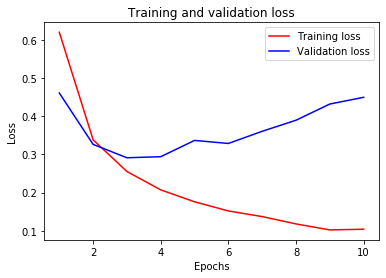

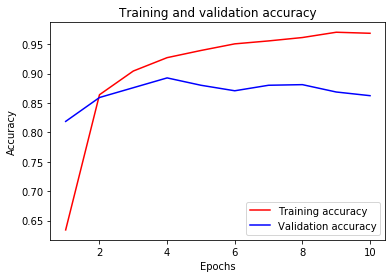

In [0]:
import matplotlib.pyplot as plt

acc = training_dict['accuracy']
val_acc = training_dict['val_accuracy']
loss = training_dict['loss']
val_loss = training_dict['val_loss']

epochs = range(1, 10 + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
